# Wind Power Generation Prediction By Weather Prediction Using RNN

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as pltdt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import keras.backend as K
from sklearn import preprocessing
from sklearn.metrics import explained_variance_score
from keras.layers import Dropout

Using TensorFlow backend.


## Data Reading, Cleaning, Mapping

### Read All Power Dataset and Weather Dataset for France in 10 Years

In [2]:
power_countries_1986_2015 = pd.read_csv("EMHIRESPV_TSh_CF_Country_19862015.csv")
meteorological_france_2006_2015 = pd.read_csv("france_2006_2015_ver2_0_9258_487749847.csv", sep=";")

In [3]:
power_countries_1986_2015.shape

(262968, 29)

In [4]:
meteorological_france_2006_2015.shape

(3662956, 16)

## Power from Hours to Days, Choose 10 Yesrs of France

In [6]:
t_h = pd.date_range('1/1/1986', periods=262968, freq='H')
power_countries_1986_2015["HOUR"] = t_h
power_countries_1986_2015.set_index("HOUR", inplace = True)
power_countries_1986_2015['DAY']=power_countries_1986_2015.index.map(lambda x: x.strftime('%Y-%m-%d'))
power_countries_1986_2015_day = power_countries_1986_2015.groupby('DAY').mean()
power_countries_2006_2015_day = power_countries_1986_2015_day.loc["2006-01-01":"2015-12-31"]
t_d = pd.date_range('1/1/2006', periods=3652, freq='D')
power_france_2006_2015_day = power_countries_2006_2015_day["FR"]
power_france_2006_2015_day.head()

DAY
2006-01-01    0.040878
2006-01-02    0.050066
2006-01-03    0.046397
2006-01-04    0.061315
2006-01-05    0.042258
Name: FR, dtype: float64

## Aggregate Weather Dataset for Whole France

In [8]:
meteorological_france_2006_2015_day = meteorological_france_2006_2015.groupby('DAY').mean()
meteorological_france_2006_2015_day["DAY"] = t_d
meteorological_france_2006_2015_day.set_index("DAY", inplace=True)
meteorological_france_2006_2015_day = \
    meteorological_france_2006_2015_day.\
        drop(meteorological_france_2006_2015_day.columns[[0, 1, 2, 3, -1]], axis=1) 
print(meteorological_france_2006_2015_day.head())

            TEMPERATURE_MAX  TEMPERATURE_MIN  TEMPERATURE_AVG  WINDSPEED  \
DAY                                                                        
2006-01-01         7.536590         2.931306         5.234895   5.001097   
2006-01-02         6.788734         3.453141         5.121934   3.652941   
2006-01-03         6.067498         1.962014         4.015254   2.862612   
2006-01-04         4.679661         0.788136         2.735593   3.160020   
2006-01-05         2.080359        -1.576869         0.251147   2.734397   

            VAPOURPRESSURE  PRECIPITATION        E0       ES0       ET0  \
DAY                                                                       
2006-01-01        7.792114       5.722333  0.436790  0.381186  0.614905   
2006-01-02        7.303749       0.465204  0.439681  0.380588  0.664437   
2006-01-03        6.738744       0.682253  0.447258  0.389910  0.617697   
2006-01-04        6.270528       0.615753  0.361645  0.308963  0.562512   
2006-01-05       

## Data Shifting

In [9]:
france_2006_2015_day_up1 = meteorological_france_2006_2015_day.shift(-1)
france_2006_2015_day_up2 = meteorological_france_2006_2015_day.shift(-2)
france_2006_2015_day_down1 = meteorological_france_2006_2015_day.shift(1)
france_2006_2015_day_down2 = meteorological_france_2006_2015_day.shift(2)
france_2006_2015_day_5days = pd.concat([meteorological_france_2006_2015_day,\
                                        france_2006_2015_day_up1, france_2006_2015_day_up2, \
                                        france_2006_2015_day_down1, \
                                       france_2006_2015_day_down2], axis=1)

fr_p = power_france_2006_2015_day.rename('fr')
meteorological_france_2006_2015_day_shif = france_2006_2015_day_5days

for i in range(1, 14):
    fr_p_shift = fr_p.shift(-1)
    meteorological_france_2006_2015_day_shif = \
        pd.concat([fr_p_shift, meteorological_france_2006_2015_day_shif], axis=1)
    fr_p = fr_p_shift
    
print(meteorological_france_2006_2015_day_shif.head())

                  fr        fr        fr        fr        fr        fr  \
DAY                                                                      
2006-01-01  0.116344  0.089186  0.054274  0.068600  0.076414  0.064127   
2006-01-02  0.105823  0.116344  0.089186  0.054274  0.068600  0.076414   
2006-01-03  0.051696  0.105823  0.116344  0.089186  0.054274  0.068600   
2006-01-04  0.024062  0.051696  0.105823  0.116344  0.089186  0.054274   
2006-01-05  0.024392  0.024062  0.051696  0.105823  0.116344  0.089186   

                  fr        fr        fr        fr     ...       \
DAY                                                    ...        
2006-01-01  0.047271  0.039511  0.062992  0.042258     ...        
2006-01-02  0.064127  0.047271  0.039511  0.062992     ...        
2006-01-03  0.076414  0.064127  0.047271  0.039511     ...        
2006-01-04  0.068600  0.076414  0.064127  0.047271     ...        
2006-01-05  0.054274  0.068600  0.076414  0.064127     ...        

           

## The Final Dataset, Save Object for RNN

In [11]:
meteorological_france_2006_2015_day_shif\
    = pd.concat([power_france_2006_2015_day, meteorological_france_2006_2015_day_shif], axis=1)

meteorological_france_2006_2015_day_shif.to_pickle("wind_dataset_fr_shift1218_5days")

# RNN Model Building and Test

## Read Saved DataFrame

In [13]:
df = pd.read_pickle('wind_dataset_fr_shift1218_5days')
print(df.head())

                  FR        fr        fr        fr        fr        fr  \
DAY                                                                      
2006-01-01  0.040878  0.116344  0.089186  0.054274  0.068600  0.076414   
2006-01-02  0.050066  0.105823  0.116344  0.089186  0.054274  0.068600   
2006-01-03  0.046397  0.051696  0.105823  0.116344  0.089186  0.054274   
2006-01-04  0.061315  0.024062  0.051696  0.105823  0.116344  0.089186   
2006-01-05  0.042258  0.024392  0.024062  0.051696  0.105823  0.116344   

                  fr        fr        fr        fr     ...       \
DAY                                                    ...        
2006-01-01  0.064127  0.047271  0.039511  0.062992     ...        
2006-01-02  0.076414  0.064127  0.047271  0.039511     ...        
2006-01-03  0.068600  0.076414  0.064127  0.047271     ...        
2006-01-04  0.054274  0.068600  0.076414  0.064127     ...        
2006-01-05  0.089186  0.054274  0.068600  0.076414     ...        

           

## Training(2006-2014) and Test(2015)

In [14]:
df.index = pd.to_datetime(df.index)
df.index
df = df.loc["2006-01-03":"2015-12-18"]
all_y = df['FR'].values
all_X = df.drop('FR', axis=1).values
train_df = df.loc["2006-01-03":"2014-12-31"]
test_df = df.loc["2015-01-01":"2015-12-18"]
train_y = train_df['FR'].values
train_X = train_df.drop('FR', axis=1).values
test_y = test_df['FR'].values
text_X = test_df.drop('FR', axis=1).values
X_all = preprocessing.scale(all_X)
X_train = preprocessing.scale(train_X)
X_test = preprocessing.scale(text_X)

## Save Feathers Plot for Report as X.png

In [18]:
ax = pd.DataFrame(X_all).plot\
    (legend='reverse', alpha=1, title="Weather Feathers", \
     kind="line", colormap="prism", figsize=(25, 10), linewidth=1, linestyle=':')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), prop={'size': 7})
fig = ax.get_figure()
fig.savefig('X.png') 

## Save Power Plot for Report as Y.png

In [19]:
df["FR"].plot(title="Power Generation", kind="line", colormap="summer", figsize=(25, 10))
ax = test_df["FR"].plot(title="Power Generation", kind="line", colormap="flag", figsize=(25, 10))
fig = ax.get_figure()
fig.savefig('Y.png') 

## Re-dimensioned for LSTM layer

In [20]:
X_train_w = X_train.reshape(train_X.shape[0], 1, 63)
X_test_w = X_test.reshape(text_X.shape[0], 1, 63)
X_train_w.shape

(3285, 1, 63)

## Build the Model

In [22]:
K.clear_session()

in_sh = (1, 63) 
hidden_1= 2000
hidden_2= 2000
hidden_3= 2000
hidden_4= 2000
hidden_5= 2000
hidden_6= 2000
hidden_7= 2000
hidden_8= 2000
hidden_9= 2000
hidden_10= 2000
hidden_11= 2000
hidden_12= 2000
hidden_13= 2000
hidden_14= 2000
hidden_15= 2000
hidden_16= 2000
hidden_17= 2000
hidden_18= 2000
hidden_19= 2000
outputs = 1

model = Sequential()
model.add(LSTM(hidden_1, input_shape = in_sh,))
model.add(Dense(hidden_2, activation = 'relu'))
model.add(Dense(hidden_3, activation = 'relu'))
model.add(Dense(hidden_4, activation = 'relu'))
model.add(Dense(hidden_5, activation = 'relu'))
model.add(Dense(hidden_6, activation = 'relu'))
# model.add(Dropout(0.23))
model.add(Dense(hidden_7, activation = 'relu'))
model.add(Dense(hidden_8, activation = 'relu'))
model.add(Dense(hidden_9, activation = 'relu'))
model.add(Dense(hidden_10, activation = 'relu'))
# model.add(Dense(hidden_11, activation = 'relu'))
# model.add(Dense(hidden_12, activation = 'relu'))
# model.add(Dense(hidden_13, activation = 'relu'))
# model.add(Dense(hidden_14, activation = 'relu'))
# model.add(Dense(hidden_15, activation = 'relu'))
# model.add(Dense(hidden_16, activation = 'relu'))
# model.add(Dense(hidden_17, activation = 'relu'))
# model.add(Dense(hidden_18, activation = 'relu'))
# model.add(Dense(hidden_19, activation = 'relu'))
model.add(Dense(outputs))
model.compile(optimizer='adam', loss='mean_squared_error',)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2000)              16512000  
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_5 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_6 (Dense)              (None, 2000)              4002000   
__________

## Set Stop Params

In [23]:
early_stop = EarlyStopping(monitor = 'loss', patience = 10, verbose = 1)

## Run Model and Settings

In [24]:
eps = 500
bs = 300

history \
    = model.fit(X_train_w, train_y, epochs = eps,\
                batch_size = bs, verbose = 1 , callbacks = [early_stop])

Epoch 1/500


 300/3285 [=>............................] - ETA: 58s - loss: 0.0203

 600/3285 [====>.........................] - ETA: 26s - loss: 11.6306



 900/3285 [=======>......................] - ETA: 16s - loss: 7.7559 

1200/3285 [=========>....................] - ETA: 10s - loss: 5.8203

1500/3285 [============>.................] - ETA: 7s - loss: 4.6587 

1800/3285 [===============>..............] - ETA: 5s - loss: 3.8829

2100/3285 [==================>...........] - ETA: 3s - loss: 3.3320

2400/3285 [====================>.........] - ETA: 2s - loss: 2.9159



2700/3285 [=======================>......] - ETA: 1s - loss: 2.5928

3000/3285 [==========================>...] - ETA: 0s - loss: 2.3345

3285/3285 [==============================] - 7s 2ms/step - loss: 2.1329


Epoch 2/500
 300/3285 [=>............................] - ETA: 1s - loss: 0.0078

 600/3285 [====>.........................] - ETA: 0s - loss: 0.0072

 900/3285 [=======>......................] - ETA: 0s - loss: 0.0061

1200/3285 [=========>....................] - ETA: 0s - loss: 0.0061



1500/3285 [============>.................] - ETA: 0s - loss: 0.0056

1800/3285 [===============>..............] - ETA: 0s - loss: 0.0051

2100/3285 [==================>...........] - ETA: 0s - loss: 0.0048

2400/3285 [====================>.........]

 - ETA: 0s - loss: 0.0045

2700/3285 [=======================>......] - ETA: 0s - loss: 0.0041

3000/3285 [==========================>...] - ETA: 0s - loss: 0.0040

3285/3285 [==============================] - 1s 337us/step - loss: 0.0037


Epoch 3/500
 300/3285 [=>............................] - ETA: 0s - loss: 0.0016

 600/3285 [====>.........................] - ETA: 0s - loss: 0.0015

 900/3285 [=======>......................] - ETA: 0s - loss: 0.0014



1200/3285 [=========>....................] - ETA: 0s - loss: 0.0014

1500/3285 [============>.................] - ETA: 0s - loss: 0.0015

1800/3285 [===============>..............] - ETA: 0s - loss: 0.0014



2100/3285 [==================>...........] - ETA: 0s - loss: 0.0014

2400/3285 [====================>.........] - ETA: 0s - loss: 0.0013

2700/3285 [=======================>......] - ETA: 0s - loss: 0.0013

3000/3285 [==========================>...] - ETA: 0s - loss: 0.0013

3285/3285 [==============================] - 1s 338us/step - loss: 0.0013


Epoch 4/500


 300/3285 [=>............................] - ETA: 1s - loss: 0.0011

 600/3285 [====>.........................] - ETA: 0s - loss: 0.0011

 900/3285 [=======>......................] - ETA: 0s - loss: 0.0011

1200/3285 [=========>....................] - ETA: 0s - loss: 0.0011

1500/3285 [============>.................] - ETA: 0s - loss: 0.0011

1800/3285 [===============>..............] - ETA: 0s - loss: 0.0011



2100/3285 [==================>...........] - ETA: 0s - loss: 0.0011

2400/3285 [====================>.........] - ETA: 0s - loss: 0.0011

2700/3285 [=======================>......] - ETA: 0s - loss: 0.0011

3000/3285 [==========================>...] - ETA: 0s - loss: 0.0011

3285/3285 [==============================] - 1s 338us/step - loss: 0.0011


Epoch 5/500
 300/3285 [=>............................] - ETA: 1s - loss: 0.0010



 600/3285 [====>.........................] - ETA: 0s - loss: 0.0010

 900/3285 [=======>......................] - ETA: 0s - loss: 0.0011

1200/3285 [=========>....................] - ETA: 0s - loss: 0.0011

1500/3285 [============>.................] - ETA: 0s - loss: 0.0011

1800/3285 [===============>..............] - ETA: 0s - loss: 0.0011

2100/3285 [==================>...........] - ETA: 0s - loss: 0.0011

2400/3285 [====================>.........] - ETA: 0s - loss: 0.0011

2700/3285 [=======================>......] - ETA: 0s - loss: 0.0011

3000/3285 [==========================>...] - ETA: 0s - loss: 0.0010

3285/3285 [==============================] - 1s 338us/step - loss: 0.0010


Epoch 6/500
 300/3285 [=>............................] - ETA: 1s - loss: 9.1980e-04



 600/3285 [====>.........................] - ETA: 0s - loss: 0.0010    

 900/3285 [=======>......................] - ETA: 0s - loss: 0.0010

1200/3285 [=========>....................] - ETA: 0s - loss: 0.0010

1500/3285 [============>.................] - ETA: 0s - loss: 0.0010

1800/3285 [===============>..............] - ETA: 0s - loss: 0.0010

2100/3285 [==================>...........] - ETA: 0s - loss: 9.9546e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 0.0010    

2700/3285 [=======================>......] - ETA: 0s - loss: 0.0010

3000/3285 [==========================>...] - ETA: 0s - loss: 0.0010

3285/3285 [==============================] - 1s 337us/step - loss: 9.9924e-04


Epoch 7/500


 300/3285 [=>............................] - ETA: 1s - loss: 9.4971e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 9.4827e-04



 900/3285 [=======>......................] - ETA: 0s - loss: 9.8339e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 9.7125e-04

1500/3285 [============>.................] - ETA: 0s - loss: 9.7223e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 9.8888e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 9.9397e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 9.8776e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 9.8816e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 9.8202e-04

3285/3285 [==============================] - 1s 338us/step - loss: 9.7966e-04


Epoch 8/500
 300/3285 [=>............................] - ETA: 1s - loss: 8.3502e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 9.7206e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 9.6191e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 9.7923e-04

1500/3285 [============>.................] - ETA: 0s - loss: 9.6969e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 9.7525e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 9.6858e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 9.6994e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 9.5497e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 9.5312e-04

3285/3285 [==============================] - 1s 336us/step - loss: 9.4509e-04


Epoch 9/500
 300/3285 [=>............................] - ETA: 1s - loss: 9.9008e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 8.9989e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 8.8832e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 8.8312e-04

1500/3285 [============>.................] - ETA: 0s - loss: 8.8754e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 8.9561e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 9.0305e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 9.0296e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 8.9244e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 8.8392e-04

3285/3285 [==============================] - 1s 338us/step - loss: 8.8813e-04


Epoch 10/500
 300/3285 [=>............................] - ETA: 0s - loss: 7.4968e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 7.5080e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 7.9864e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 8.1815e-04

1500/3285 [============>.................] - ETA: 0s - loss: 8.1261e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 7.8303e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 7.8719e-04



2400/3285 [====================>.........] - ETA: 0s - loss: 7.7538e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 7.6152e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 7.5830e-04

3285/3285 [==============================] - 1s 338us/step - loss: 7.6763e-04


Epoch 11/500
 300/3285 [=>............................] - ETA: 1s - loss: 8.2419e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 7.5878e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 7.2749e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 7.0774e-04

1500/3285 [============>.................] - ETA: 0s - loss: 7.2426e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 7.0720e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 6.9662e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 6.8630e-04



2700/3285 [=======================>......] - ETA: 0s - loss: 6.7091e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 6.6877e-04

3285/3285 [==============================] - 1s 338us/step - loss: 6.6596e-04


Epoch 12/500
 300/3285 [=>............................] - ETA: 0s - loss: 5.3807e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 5.3539e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 5.9258e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 6.6730e-04

1500/3285 [============>.................] - ETA: 0s - loss: 7.0191e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 6.9635e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 7.0488e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 6.9677e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 6.8450e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 6.7701e-04

3285/3285 [==============================] - 1s 337us/step - loss: 6.7669e-04


Epoch 13/500
 300/3285 [=>............................] - ETA: 1s - loss: 6.1655e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 6.1409e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 5.8120e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 5.7725e-04



1500/3285 [============>.................] - ETA: 0s - loss: 5.5942e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 5.8420e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 5.9299e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 5.9407e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 5.8279e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 5.7672e-04

3285/3285 [==============================] - 1s 339us/step - loss: 5.8055e-04


Epoch 14/500


 300/3285 [=>............................] - ETA: 1s - loss: 6.9684e-04



 600/3285 [====>.........................] - ETA: 0s - loss: 6.1392e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 5.8261e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 5.9348e-04

1500/3285 [============>.................] - ETA: 0s - loss: 5.8852e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 5.8251e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 5.7465e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 5.7203e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 5.6341e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 5.5100e-04

3285/3285 [==============================] - 1s 337us/step - loss: 5.4667e-04


Epoch 15/500
 300/3285 [=>............................] - ETA: 0s - loss: 4.6544e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 4.6753e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.6001e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 4.6749e-04

1500/3285 [============>.................] - ETA: 0s - loss: 4.7405e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 4.6785e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 4.6827e-04



2400/3285 [====================>.........] - ETA: 0s - loss: 4.6679e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 4.6211e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 4.5883e-04

3285/3285 [==============================] - 1s 337us/step - loss: 4.6217e-04


Epoch 16/500
 300/3285 [=>............................] - ETA: 1s - loss: 4.2810e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 4.4891e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.6577e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 4.5937e-04

1500/3285 [============>.................] - ETA: 0s - loss: 4.6914e-04



1800/3285 [===============>..............] - ETA: 0s - loss: 4.5220e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 4.4067e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 4.4371e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 4.3319e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 4.3613e-04

3285/3285 [==============================] - 1s 338us/step - loss: 4.3430e-04


Epoch 17/500
 300/3285 [=>............................] - ETA: 0s - loss: 4.9335e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 4.5977e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.7580e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 4.7896e-04



1500/3285 [============>.................] - ETA: 0s - loss: 4.6483e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 4.5448e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 4.5466e-04



2400/3285 [====================>.........] - ETA: 0s - loss: 4.5802e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 4.6005e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 4.5408e-04

3285/3285 [==============================] - 1s 338us/step - loss: 4.5242e-04


Epoch 18/500
 300/3285 [=>............................] - ETA: 0s - loss: 3.2094e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 4.0573e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.1398e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 4.1328e-04

1500/3285 [============>.................] - ETA: 0s - loss: 4.2911e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 4.2205e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 4.1765e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 4.1697e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 4.1302e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 4.1413e-04

3285/3285 [==============================] - 1s 336us/step - loss: 4.0871e-04


Epoch 19/500
 300/3285 [=>............................] - ETA: 0s - loss: 4.3214e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.9470e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.1015e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.9799e-04

1500/3285 [============>.................] - ETA: 0s - loss: 3.8463e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.7714e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 3.7218e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 3.7826e-04



2700/3285 [=======================>......] - ETA: 0s - loss: 3.7589e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.8649e-04

3285/3285 [==============================] - 1s 337us/step - loss: 3.8575e-04


Epoch 20/500
 300/3285 [=>............................] - ETA: 0s - loss: 3.9659e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 4.1013e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 3.7465e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.6838e-04

1500/3285 [============>.................] - ETA: 0s - loss: 3.6215e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.6597e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 3.6907e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 3.6352e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 3.6113e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.5674e-04

3285/3285 [==============================] - 1s 336us/step - loss: 3.5401e-04


Epoch 21/500


 300/3285 [=>............................] - ETA: 1s - loss: 3.7195e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.3724e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 3.3230e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.4308e-04

1500/3285 [============>.................] - ETA: 0s - loss: 3.4290e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.4064e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 3.3234e-04



2400/3285 [====================>.........] - ETA: 0s - loss: 3.3000e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 3.2557e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.2023e-04

3285/3285 [==============================] - 1s 336us/step - loss: 3.1266e-04


Epoch 22/500
 300/3285 [=>............................] - ETA: 0s - loss: 2.7547e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 2.9079e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 2.8731e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.7081e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.7498e-04



1800/3285 [===============>..............] - ETA: 0s - loss: 2.7379e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 2.7082e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.7164e-04



2700/3285 [=======================>......] - ETA: 0s - loss: 2.8035e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 2.7817e-04

3285/3285 [==============================] - 1s 338us/step - loss: 2.9282e-04


Epoch 23/500


 300/3285 [=>............................] - ETA: 0s - loss: 7.1015e-04



 600/3285 [====>.........................] - ETA: 0s - loss: 7.1509e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 6.3689e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 5.9793e-04

1500/3285 [============>.................] - ETA: 0s - loss: 5.7358e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 5.5491e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 5.5611e-04



2400/3285 [====================>.........] - ETA: 0s - loss: 5.3749e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 5.2081e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 5.0774e-04

3285/3285 [==============================] - 1s 338us/step - loss: 4.8642e-04


Epoch 24/500


 300/3285 [=>............................] - ETA: 0s - loss: 3.0973e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.9980e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 4.7705e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 5.0514e-04

1500/3285 [============>.................] - ETA: 0s - loss: 5.2405e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 5.4759e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 5.1684e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 5.1085e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 4.9950e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 4.9083e-04

3285/3285 [==============================] - 1s 337us/step - loss: 4.8540e-04


Epoch 25/500


 300/3285 [=>............................] - ETA: 0s - loss: 3.2933e-04



 600/3285 [====>.........................] - ETA: 0s - loss: 3.3671e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 3.1408e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.2462e-04

1500/3285 [============>.................] - ETA: 0s - loss: 3.1232e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.1023e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 3.0935e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 3.1309e-04



2700/3285 [=======================>......] - ETA: 0s - loss: 3.1316e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.0933e-04



3285/3285 [==============================] - 1s 338us/step - loss: 3.1773e-04


Epoch 26/500


 300/3285 [=>............................] - ETA: 1s - loss: 3.1926e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.2852e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 3.1213e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.0427e-04

1500/3285 [============>.................] - ETA: 0s - loss: 3.0744e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.0413e-04

2100/3285 [==================>...........]

 - ETA: 0s - loss: 2.9719e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.8581e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 2.8079e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 2.8015e-04

3285/3285 [==============================] - 1s 338us/step - loss: 2.8247e-04


Epoch 27/500
 300/3285 [=>............................] - ETA: 0s - loss: 2.4893e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.1786e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 2.9763e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.8749e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.9403e-04



1800/3285 [===============>..............] - ETA: 0s - loss: 2.8770e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 2.9889e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.9667e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 3.1749e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.1680e-04

3285/3285 [==============================] - 1s 339us/step - loss: 3.2671e-04


Epoch 28/500
 300/3285 [=>............................] - ETA: 1s - loss: 2.7331e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 3.4014e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 3.0674e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 3.2341e-04



1500/3285 [============>.................] - ETA: 0s - loss: 3.2832e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 3.1198e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 3.0719e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 3.0370e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 3.0067e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 3.0079e-04

3285/3285 [==============================] - 1s 346us/step - loss: 2.9463e-04


Epoch 29/500


 300/3285 [=>............................] - ETA: 0s - loss: 2.1865e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 2.3601e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 2.2168e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.1278e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.1400e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 2.3015e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 2.3786e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.4047e-04



2700/3285 [=======================>......] - ETA: 0s - loss: 2.4901e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 2.4990e-04

3285/3285 [==============================] - 1s 343us/step - loss: 2.6084e-04


Epoch 30/500


 300/3285 [=>............................] - ETA: 0s - loss: 2.2137e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 2.8720e-04



 900/3285 [=======>......................] - ETA: 0s - loss: 2.8050e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.7681e-04



1500/3285 [============>.................] - ETA: 0s - loss: 2.6764e-04



1800/3285 [===============>..............] - ETA: 0s - loss: 2.7966e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 2.7365e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.7538e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 2.7064e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 2.6742e-04

3285/3285 [==============================] - 1s 338us/step - loss: 2.6250e-04


Epoch 31/500


 300/3285 [=>............................] - ETA: 0s - loss: 2.6160e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 2.2231e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 2.3439e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.3627e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.3481e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 2.4009e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 2.4580e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.4343e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 2.3581e-04



3000/3285 [==========================>...] - ETA: 0s - loss: 2.3382e-04

3285/3285 [==============================] - 1s 338us/step - loss: 2.4056e-04


Epoch 32/500


 300/3285 [=>............................] - ETA: 0s - loss: 1.9109e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 2.2588e-04



 900/3285 [=======>......................] - ETA: 0s - loss: 2.3269e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.2322e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.2032e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 2.1480e-04

2100/3285 [==================>...........] - ETA: 0s - loss: 2.1340e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.1088e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 2.0907e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 2.0506e-04

3285/3285 [==============================] - 1s 337us/step - loss: 2.0603e-04


Epoch 33/500
 300/3285 [=>............................] - ETA: 0s - loss: 1.9909e-04

 600/3285 [====>.........................] - ETA: 0s - loss: 1.9008e-04

 900/3285 [=======>......................] - ETA: 0s - loss: 2.1218e-04

1200/3285 [=========>....................] - ETA: 0s - loss: 2.0153e-04

1500/3285 [============>.................] - ETA: 0s - loss: 2.0207e-04

1800/3285 [===============>..............] - ETA: 0s - loss: 2.1091e-04



2100/3285 [==================>...........] - ETA: 0s - loss: 2.0304e-04

2400/3285 [====================>.........] - ETA: 0s - loss: 2.0379e-04

2700/3285 [=======================>......] - ETA: 0s - loss: 2.0015e-04

3000/3285 [==========================>...] - ETA: 0s - loss: 2.0512e-04

3285/3285 [==============================] - 1s 340us/step - loss: 2.0531e-04


## Save Loss for Report (loss1.png)

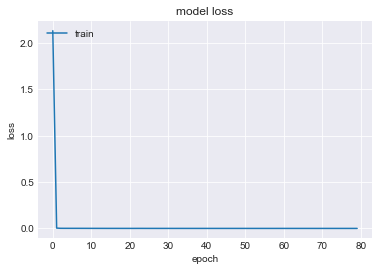

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss1.png')

## Accuracy for Test

In [25]:
pred_y = model.predict(X_test_w)
explained_variance_score(test_y, pred_y)

0.9587285287806383

## Re-train

In [28]:
early_stop = EarlyStopping(monitor = 'loss', patience = 1, verbose = 1)
eps = 500
bs = 3287

history \
    = model.fit(X_train_w, train_y, epochs = eps,\
                batch_size = bs, verbose = 1 , callbacks = [early_stop])

Epoch 1/500


3285/3285 [==============================] - 0s 129us/step - loss: 1.1458e-04


Epoch 2/500


3285/3285 [==============================] - 0s 122us/step - loss: 8.2621e-05


Epoch 3/500


3285/3285 [==============================] - 0s 120us/step - loss: 9.7137e-05


Epoch 00003: early stopping


In [29]:
pred_y = model.predict(X_test_w)
explained_variance_score(test_y, pred_y)

0.96115400680277352

# Accuracy Can be Improvment by Optimazing Params, but overall will >96%

## Save Prediction for Report (foo#.png)

In [32]:
plt.figure(figsize=(25,8))
plt.plot(test_y, color='cyan', linewidth=4)
plt.plot(pred_y, color='red', linewidth=4, linestyle='dashed')

plt.savefig('foo3.png')